In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import glob
import tensorflow as tf

Using TensorFlow backend.


In [2]:
#saving slides and tumor masks in to lists

slides = []
tumors = []
slidenames = []
tumornames = []

#modify this to ur directory
s_url = "C:/Users/Reem/Downloads/slides/"

for slide in os.listdir(s_url):
    if "tif" in slide and '38' not in slide: #tumor_38 has no mask
        if "mask" in slide:
            tumors.append(open_slide(s_url + slide))
            tumornames.append(slide)
        else:
            slides.append(open_slide(s_url + slide))
            slidenames.append(slide)
      
    
#checking if the lists contain the sildes and tumor masks:
print("There are %d in Slides list." % len(slides))
print("There are %d in Tumors list." % len(tumors))


There are 21 in Slides list.
There are 21 in Tumors list.


In [3]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

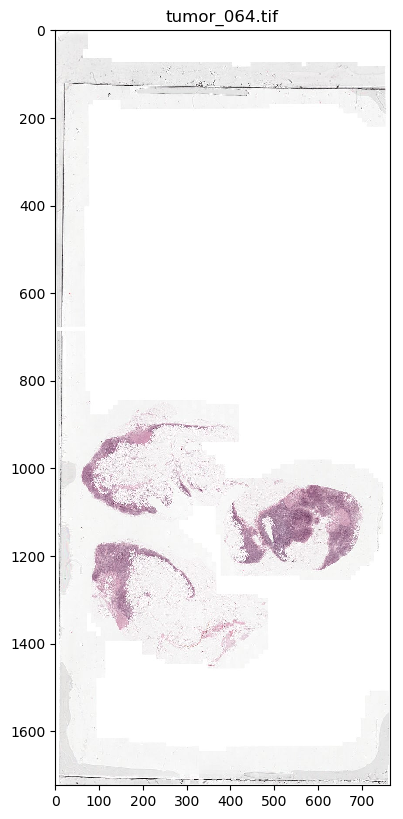

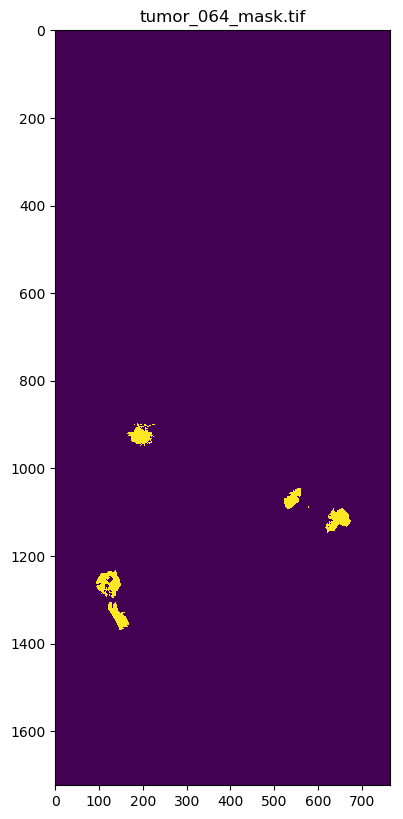

In [4]:
#testing a slide and a tumor from the lists
level_n = 7

s_num = 11

slide_image = read_slide(slides[s_num], 
                         x=0, 
                         y=0, 
                         level=level_n, 
                         width=slides[s_num].level_dimensions[level_n][0], 
                         height=slides[s_num].level_dimensions[level_n][1])

plt.figure(figsize=(10,10), dpi=100)
plt.title(slidenames[s_num])
plt.imshow(slide_image)

mask_image = read_slide(tumors[s_num], 
                        x=0, 
                        y=0, 
                        level=level_n, 
                        width=tumors[s_num].level_dimensions[level_n][0], 
                        height=tumors[s_num].level_dimensions[level_n][1])


mask_image = mask_image[:,:,0]
plt.figure(figsize=(10,10), dpi=100)
plt.title(tumornames[s_num])
plt.imshow(mask_image)

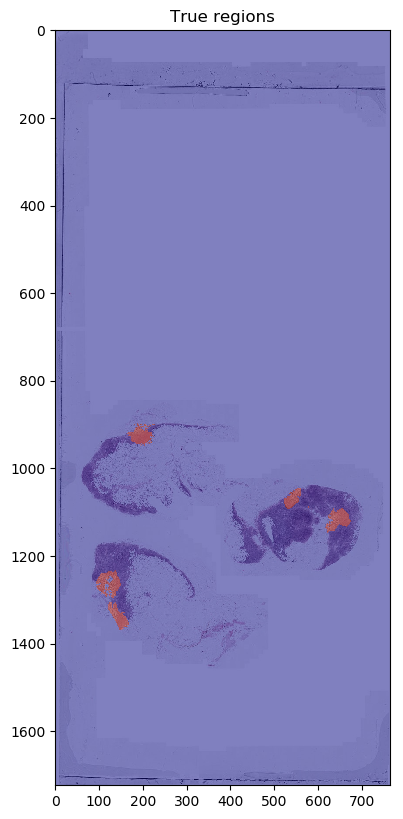

In [26]:
#showing the image and the heatmap on top of each other
plt.figure(figsize=(10,10), dpi=100)
plt.title('True regions')
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.
plt.savefig('C:/Users/Reem/Documents/DL_course_project/Image testing/'+'True regions'+slidenames[11])


In [5]:
#slicing images for training

level_n = 4
#taking 6 slide for training and the rest for testing
train_slides = slides[12:18]
train_tumors = tumors[12:18]
downsample = int(slides[0].level_downsamples[level_n])

x = []
y = []
y_mask = []
count = 0

for slide, tumor in zip(train_slides, train_tumors):
    count+=1
    for i in np.arange(0,slide.level_dimensions[level_n][0],150):
        for j in np.arange(0,slide.level_dimensions[level_n][1],150):
            x.append(read_slide(slide,x=i*downsample, y=j*downsample, level=level_n, width=150, height=150))
            y_region = read_slide(tumor, x=i*downsample, y=j*downsample, level=level_n, width=150, height=150)[:,:,0]
            y_mask.append(y_region)
            #creating labels
            if np.array(np.where(y_region>0)).shape[1] > 0:
                y.append(1)
            else:
                y.append(0)
    
    
x = np.array(x)
y = np.array(y)

#preprocess
x = x/255.0

print(x.shape)
print(y.shape)

(8436, 150, 150, 3)
(8436,)


In [6]:
#divide into train and validate

d_num = 6500

x_train, y_train = x[:d_num], y[:d_num] 
x_valid, y_valid = x[d_num:], y[d_num:]
x_train.shape, x_valid.shape

((6500, 150, 150, 3), (1936, 150, 150, 3))

In [7]:
#creating the model 
conv_base = tf.keras.applications.InceptionV3(weights='imagenet',
                  include_top=False, input_shape = (150, 150, 3))

model = tf.keras.models.Sequential()
model.add(conv_base)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

conv_base.trainable = False


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               9437696   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 31,240,993
Trainable params: 9,438,209
Non-trainable params: 21,802,784
_________________________________________________________________


In [8]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

In [9]:
model.compile(loss='binary_crossentropy',
             optimizer = tf.keras.optimizers.RMSprop(lr=2e-5),
             metrics = ['acc'])

history = model.fit(x_train, y_train, epochs=10)

Epoch 1/10
6500/6500 [==============================] - 43s 7ms/step - loss: 0.2298 - acc: 0.9363
Epoch 2/10
6500/6500 [==============================] - 30s 5ms/step - loss: 0.1514 - acc: 0.9454
Epoch 3/10
6500/6500 [==============================] - 29s 5ms/step - loss: 0.1303 - acc: 0.9548
Epoch 4/10
6500/6500 [==============================] - 30s 5ms/step - loss: 0.1194 - acc: 0.9545
Epoch 5/10
6500/6500 [==============================] - 31s 5ms/step - loss: 0.1090 - acc: 0.9591
Epoch 6/10
6500/6500 [==============================] - 30s 5ms/step - loss: 0.1086 - acc: 0.9608
Epoch 7/10
6500/6500 [==============================] - 30s 5ms/step - loss: 0.0979 - acc: 0.9638
Epoch 8/10
6500/6500 [==============================] - 29s 4ms/step - loss: 0.0969 - acc: 0.9608
Epoch 9/10
6500/6500 [==============================] - 30s 5ms/step - loss: 0.0902 - acc: 0.9657
Epoch 10/10
6500/6500 [==============================] - 29s 4ms/step - loss: 0.0870 - acc: 0.9691


In [10]:
test_loss, test_acc = model.evaluate(x_valid, y_valid)
test_loss, test_acc

1936/1936 [==============================] - 11s 6ms/step


(0.09289900126505243, 0.9643595041322314)

In [11]:
#fine tuning the inception model
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'conv2d_71':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
model.compile(loss='binary_crossentropy',
             optimizer = tf.keras.optimizers.RMSprop(lr=2e-5),
             metrics = ['acc'])

history = model.fit(x_train, y_train, epochs=10)

Epoch 1/10
6500/6500 [==============================] - 47s 7ms/step - loss: 0.0854 - acc: 0.9695
Epoch 2/10
6500/6500 [==============================] - 38s 6ms/step - loss: 0.0673 - acc: 0.9749
Epoch 3/10
6500/6500 [==============================] - 44s 7ms/step - loss: 0.0632 - acc: 0.9769
Epoch 4/10
6500/6500 [==============================] - 47s 7ms/step - loss: 0.0484 - acc: 0.9823
Epoch 5/10
6500/6500 [==============================] - 49s 8ms/step - loss: 0.0381 - acc: 0.9857
Epoch 6/10
6500/6500 [==============================] - 47s 7ms/step - loss: 0.0366 - acc: 0.9858
Epoch 7/10
6500/6500 [==============================] - 48s 7ms/step - loss: 0.0309 - acc: 0.9885
Epoch 8/10
6500/6500 [==============================] - 46s 7ms/step - loss: 0.0343 - acc: 0.9892
Epoch 9/10
6500/6500 [==============================] - 46s 7ms/step - loss: 0.0272 - acc: 0.9915
Epoch 10/10
6500/6500 [==============================] - 50s 8ms/step - loss: 0.0276 - acc: 0.9903


In [13]:
#validation after fine-tuning
test_loss, test_acc = model.evaluate(x_valid, y_valid)
test_loss, test_acc

1936/1936 [==============================] - 10s 5ms/step


(0.09174206002992735, 0.981404958677686)

In [15]:
#testing 
test_n = 11 
level_nn = 4
slide_test = slides[test_n]
tumor_test = tumors[test_n]
downsample_t = int(slides[test_n].level_downsamples[level_nn])
x_test = []
y_test = []
y_testm = []
for i in np.arange(0,slide_test.level_dimensions[level_nn][0],150):
    for j in np.arange(0,slide_test.level_dimensions[level_nn][1],150):
        x_test.append(read_slide(slide_test,x=i*downsample_t, y=j*downsample_t, level=level_nn, width=150, height=150))
        y_region_t = read_slide(tumor_test, x=i*downsample_t, y=j*downsample_t, level=level_nn, width=150, height=150)[:,:,0]
        y_testm.append(y_region_t)
        #creating labels
        if np.array(np.where(y_region_t>0)).shape[1] > 0:
            y_test.append(1)
        else:
            y_test.append(0)
            
x_test = np.array(x_test)
y_test = np.array(y_test)
y_testm = np.array(y_testm)
  
x_test = x_test/255.0

print(x_test.shape)

(3772, 150, 150, 3)


In [30]:
#predicting the cancer regions
p_act = len(np.where(y_test>0)[0])
pred = model.predict(x_test)
p_pred = len(np.where(pred>0.8)[0])
print("Number of actual cancer patches in the slide: ", p_act)
print("Number of predicted cancer cells in the slide: ", p_pred)

Number of actual cancer patches in the slide:  64
Number of predicted cancer cells in the slide:  37


In [18]:
#creating the heatmap
test_image = read_slide(slide_test, 
                        x=0, 
                        y=0, 
                        level=level_nn, 
                        width=slide_test.level_dimensions[level_nn][0], 
                        height=slide_test.level_dimensions[level_nn][1])

test_image = test_image/255.0

copmask = np.copy(test_image)
count=0
for i in np.arange(0,test_image.shape[1],150):
    for j in np.arange(0,test_image.shape[0],150):
        if pred[count] > 0.8:
            copmask[j:j+150, i:i+150] = 1
        else:
            copmask[j:j+150, i:i+150] = 0
        count+=1
        
copmask= copmask[:,:,0]

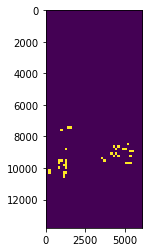

In [19]:
plt.figure()
plt.imshow(copmask)

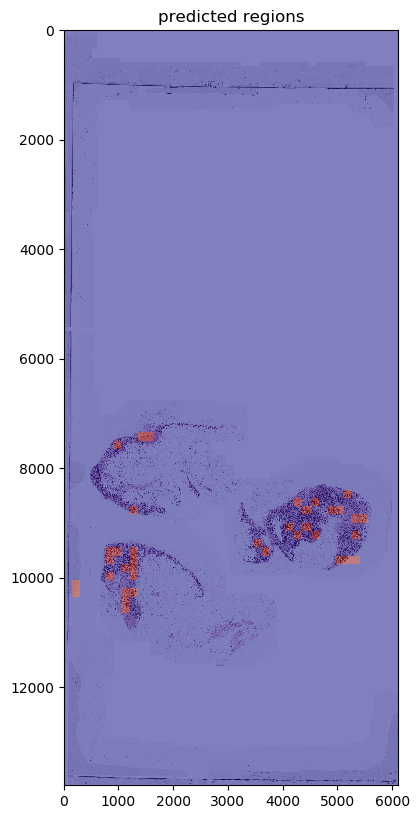

In [27]:
timage = read_slide(slide_test, 
                        x=0, 
                        y=0, 
                        level=4, 
                        width=slide_test.level_dimensions[4][0], 
                        height=slide_test.level_dimensions[4][1])
plt.figure(figsize=(10,10), dpi=100)
plt.title('predicted regions')
plt.imshow(timage)
plt.imshow(copmask, cmap='jet', alpha=0.5) # Red regions contains cancer.
#plt.savefig('C:/Users/Reem/Documents/DL_course_project/Image testing/'+'predicted regions'+slidenames[11])

In [31]:
#evaluating the predictions
total_set = x_test.shape[0]
lp = np.where(pred>0.8)[0]
la = np.where(y_test>0)[0]
la_no = np.where(y_test==0)[0]
lp_no = np.where(pred<=0.8)[0]
correct = []
wrong = []
correct_no = []
wrong_no = []

for lpi in range(0, len(lp_no)):
    if lp_no[lpi] in la_no:
        correct_no.append(lp_no[lpi])
    else:
        wrong_no.append(lp_no[lpi])
    
for lpi in range(0,len(lp)):
    if lp[lpi] in la:
        correct.append(lp[lpi])
    else:
        wrong.append(lp[lpi])
    
n_pred = total_set - p_pred
n_act = total_set - p_act
TP = len(correct)
FP = len(wrong)
TN = len(correct_no)
FN = len(wrong_no)

print("The model predicted",len(correct),"correct prediction")
print("The model predicted",len(wrong),"wrong predcition")

#calculation of confusion metrics
print("True Positives =", TP/p_act)
print("False Positives = ", FP/p_act)
print("True Negatives = ", TN/n_act)
print("False Negatives = ", FN/n_act)

The model predicted 11 correct prediction
The model predicted 26 wrong predcition
True Positives = 0.171875
False Positives =  0.40625
True Negatives =  0.9929881337648327
False Negatives =  0.014293419633225458


In [19]:
model.save("C:/Users/Reem/Documents/DL_course_project/cancer_detection_11.h5")